Preliminaries for probability

In [0]:
! pip install git+git://github.com/charlieLehman/blackjacksim
! pip install seaborn==0.9.0

  Cloning git://github.com/charlieLehman/blackjacksim to /tmp/pip-req-build-yt3zajhd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1eb_idri/wheels/f1/6b/0a/e14b8078b944f1f7574739245172611941ba3f6414f2cf1205
Successfully built blackjacksim
    100% |████████████████████████████████| 215kB 25.9MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


# Base Probabilities

Text(0.5, 1.0, 'Probabilities of various Opening Hands \n at various Shoe Sizes')

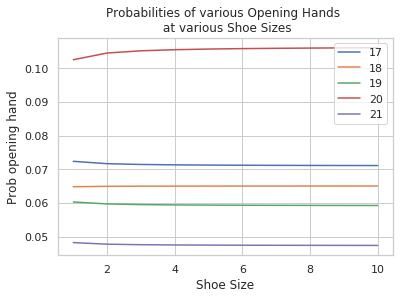

In [0]:
from scipy.special import comb
import itertools
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np


cards = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,'J':10,'Q':10,'K':10,'A':11}
card_suits = ['S','H','D','C'] 
deck = list(itertools.product(cards.keys(), card_suits))
shoe = lambda n: deck*int(n)


# combos of pairs that add to v
def count_at_value(v, shoe):
    c = 0
    _shoe = shoe.copy()
    for n in range(len(_shoe)):
        c1n, c1s = _shoe.pop(0)
        c1v = cards[c1n]
        for c2n, c2s  in _shoe:
            c2v = cards[c2n]
            val = c1v + c2v
            if val == v:
                c += 1
            elif c2n == 'A':
                c += 1 if (c1v + 1 == v) else 0
            elif c1n == 'A':
                c += 1 if (c2v + 1 == v) else 0
        
    return c
        
    
# total number of 2 card hands with shoesize n
total_2chands = lambda n: comb(52*n,2)
# prob of hand at m with shoesize n
Phandat = lambda m,n: count_at_value(m,shoe(n))/total_2chands(n)
x = np.linspace(10,1,10)

y = None
for m in [17,18,19,20,21]:
    ax = sns.lineplot(x=x,y=[Phandat(m,_x) for _x in x], label=m)
    ax.set_ylabel('Prob opening hand')
    ax.set_xlabel('Shoe Size')

ax.set_title('Probabilities of various Opening Hands \n at various Shoe Sizes')

# Simulate random games opening hands

In [0]:
import pandas as pd
import random

data = []
for shoesize in range(1,5):
    origshoe = shoe(shoesize)
    tot = total_2chands(shoesize)
    for nump in range(1,6):
        for n in range(50):
            shuffled = random.sample(origshoe, len(origshoe))
            # if there is one player the dealer's hand is removed only
            # if there are more then they are removed and a the Prob of Good
            # hand is calculated
            _shoe = shuffled[(nump*2):]
            data.append({'NumPlayers':nump,
                         'ProbStandHand':np.sum([count_at_value(v, _shoe) for v in [17,18,19,20,21]])/tot,
                         'ProbHitHand':np.sum([count_at_value(v, _shoe) for v in [10,11,12,13,14,15,16]])/tot,
                         'ProbTossHand':np.sum([count_at_value(v, _shoe) for v in [4,5,6,7,8,9]])/tot,
                        'ShoeSize':shoesize})



Text(0.5, 1.0, 'Toss')

/home/charlie/.virtualenvs/blackjack/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


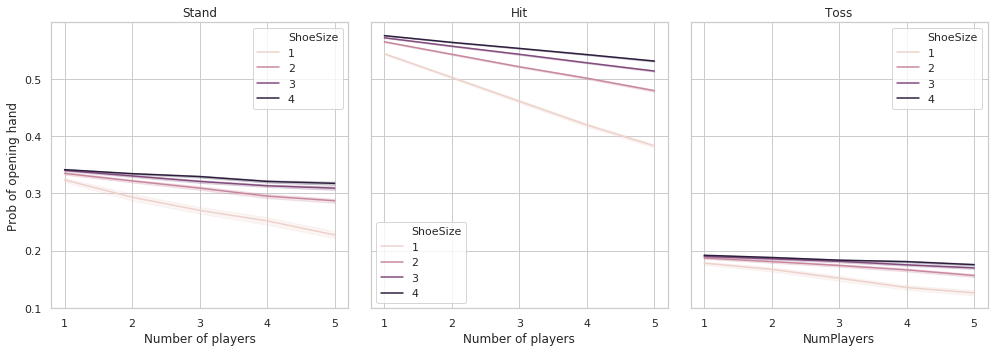

In [0]:
df = pd.DataFrame(data)
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(14,5), sharey=True)

sns.lineplot(x='NumPlayers', y='ProbStandHand', data=df, hue='ShoeSize', ax=ax[0])
sns.lineplot(x='NumPlayers', y='ProbHitHand', data=df, hue='ShoeSize', ax=ax[1])
sns.lineplot(x='NumPlayers', y='ProbTossHand', data=df, hue='ShoeSize', ax=ax[2])

ax[0].set_ylabel('Prob of opening hand')
ax[0].set_title('Stand')
ax[0].set_xlabel('Number of players')

ax[1].set_ylabel('Prob. of 2-card Hands to Hit on')
ax[1].set_xlabel('Number of players')
ax[1].set_title('Hit')
ax[2].set_title('Toss')

# Effect of Removal

# Simulate Beating Dealer in Opening Hand 1-player

In [0]:
import pandas as pd
import random
from tqdm import tnrange

data = []

def hand_value(hand):
    _hand_value = 0
    ace_count = 0
    for card in hand:
        name, suit = card
        ace_count += 1 if (name == 'A') else 0
        card_value = cards[name]
        _hand_value += card_value
    while _hand_value > 21 and ace_count > 0:
        _hand_value -= 10 
        ace_count -= 1
    return _hand_value
        
    
shoesize = 8
origshoe = shoe(shoesize)
tot = total_2chands(shoesize)
_dd = 17
_pd = 17
Phandat = lambda m,deck: count_at_value(m,deck)/comb(len(deck),2)
for n in tnrange(1000):
    money = 1000
    shuffled = random.sample(origshoe, len(origshoe))
    game = shuffled.copy()
    while len(game) >= 52 and money > 0:
        
        #Initial deal
        winnings = 0
        bet = 100
        money -= bet
        playerWin = 0
        
        #print('Initial Deal: {}'.format(len(game)))
        #Dealer's Hand
        hd = game[:2].copy()
        hd_visible = hd[0]
        del game[:2]
        dv = hand_value(hd)
        dv_init = dv

        #Player's Hand
        hp1 = game[2:4].copy()
        del game[2:4]
        pv = hand_value(hp1)
        pv_init = pv

        dealerBlackjack = dv == 21
        playerBlackjack = pv == 21

        dealerBust = playerBust = False
        if not dealerBlackjack and not playerBlackjack:
            pv_win = np.nan
            #Player Decision
            while pv < _pd:
                hp1.append(game.pop(0))
                pv = hand_value(hp1)
                if (pv > dv) and (pv <=21) and (np.isnan(pv_win)):
                    pv_win = pv
                if pv > 21:
                    playerBust = True
            #print('Player Decision: {}'.format(len(game)))

            #Dealer Decision
            while dv < _dd and not playerBust:
                hd.append(game.pop(0))
                dv = hand_value(hd)
                if dv > 21:
                    dealerBust = True
            #print('Dealer Decision: {}'.format(len(game)))

            playerWin = 1 if ((pv > dv) and (pv <= 21)) or dealerBust else 0

        if playerWin == 1:
            winnings = 2*bet if not playerBlackjack else 2.5*bet
        if (pv == dv):
            winnings = bet

        money += winnings

        data.append({
            'PlayerWin': playerWin,
            'PlayerValue': pv,
            'PlayerValueWin':pv_win,
            'DealerValue':dv,
            'InitPlayerValue': pv_init,
            'InitDealerValue':dv_init,
            'ShoeSize': shoesize,
            'Money':money,
            'Winnings':winnings,
            'PlayerDecision':_pd,
            'DealersVisible':cards[hd_visible[0]],
            'CardsInShoe':len(game),
            'DealerDecision':_dd, 
        })


df = pd.DataFrame(data)
print(df.Money.max(), df.Money.min())



2600 0


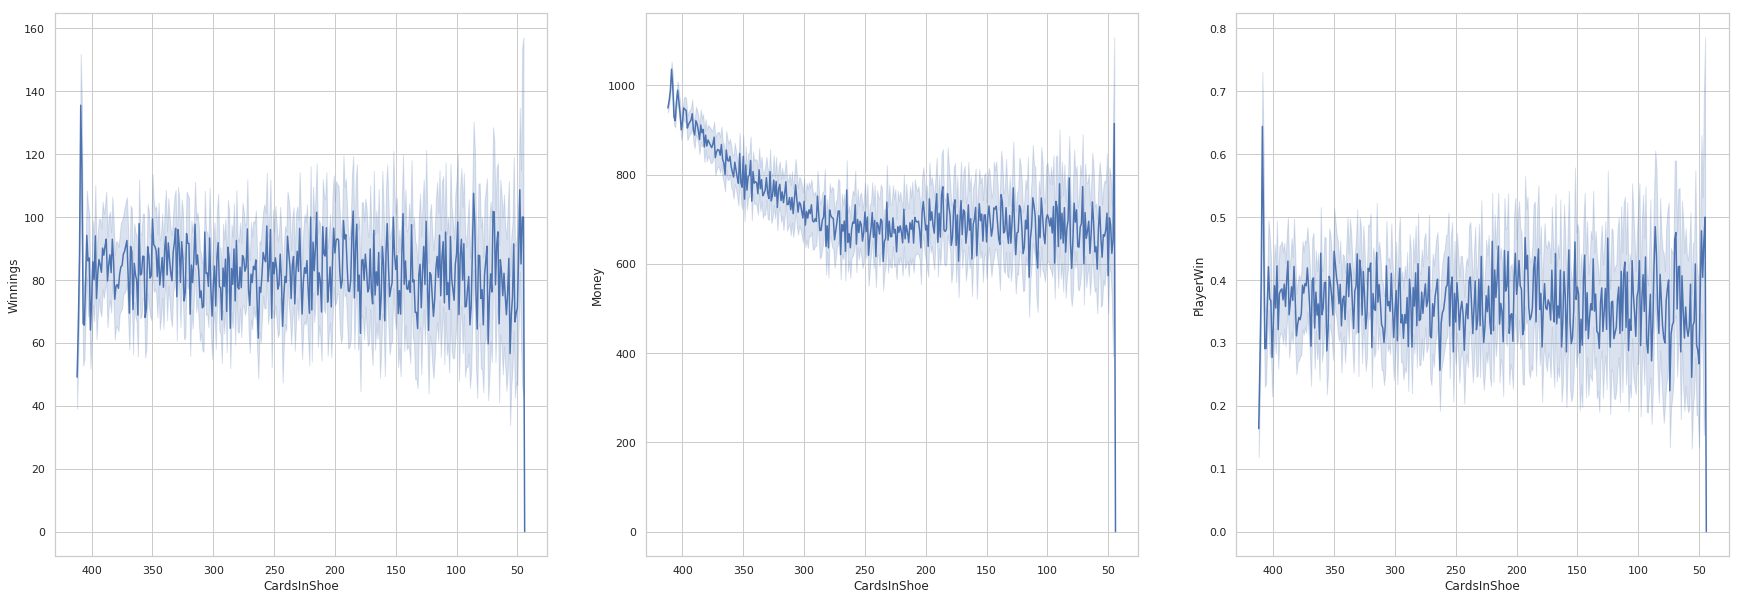

In [0]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.lineplot(x='CardsInShoe', y='Winnings', data=df, ax=ax[0])
ax[0].invert_xaxis()

sns.lineplot(x='CardsInShoe', y='Money', data=df, ax=ax[1])
ax[1].invert_xaxis()

sns.lineplot(x='CardsInShoe', y='PlayerWin', data=df, ax=ax[2])
ax[2].invert_xaxis()
plt.show()



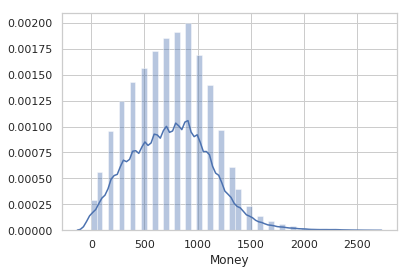

In [0]:
ax = sns.distplot(df.Money)

## Strategy Empirical

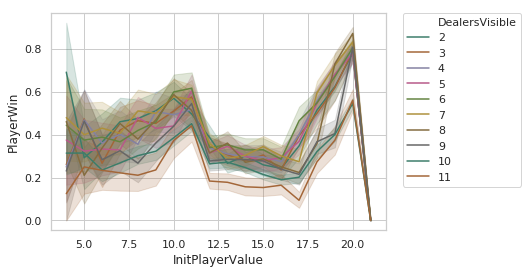

In [0]:
ax2 = sns.lineplot(x='InitPlayerValue', y='PlayerWin', hue='DealersVisible', hue_order=[2,3,4,5,6,7,8,9,10,11], legend='full', palette=sns.color_palette("Dark2", 10, desat=0.5), data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# BlackJack Simulator

In [0]:
!pip install numba

In [0]:
from blackjacksim.entities import *
from blackjacksim.strategies import basic
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from multiprocessing import Process, Manager, Pool
from numba import jit

startingPool = 3000
    
manager = Manager()
data = manager.list()
data = []

def one_round(x):
    house = Blackjack32()
    wallet = PlayerWallet(1,startingPool)
    d = Dealer()
    p = Player(basic, wallet, house)
    s = Shoe(8,.25)
    for t in range(100):
        s = p.deal(s)
        s = d.deal(s)
        s = p.play(s, d.up_card)
        s = d.play(s, p.hands)
        for h in p.hands:
            wallet.take_payout(house.payout(h, d.hand))
        rw, rp = wallet.finish_round()
        data.append({'Round':t,'Pool':wallet.wager_pool, 'Wager':rw, 'Payout':rp, 'Shoe Penetration':s._penetration_state})
        
for i in tnrange(5000):
    one_round(i)
#processes = []
#with Pool(processes=12) as pool:
#    max_ = 1000
#    with tqdm(total=max_) as pbar:
#        for i, _ in enumerate(pool.imap_unordered(one_round, range(0, max_))):
#            pbar.update()
            
df = pd.DataFrame(list(data))
df['Advantage'] = (df.Payout-df.Wager)


Text(0.5, 1.0, 'Player Advantage -0.361%')

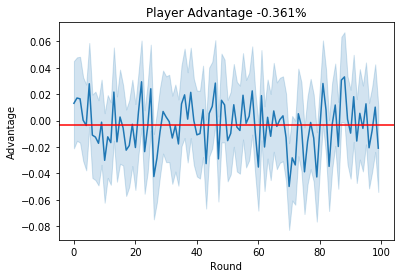

In [0]:
ax = sns.lineplot(x='Round', y='Advantage', data=df)
ax.axhline(y=df.Advantage.mean(), color='r')
ax.set_title('Player Advantage {:.3f}%'.format(df.Advantage.mean()*100))

j